# Sensitivity Calculations

In [1]:
fixed='past' # 14CO production rate fixed in past for variable models
#fixed='pres' # 14CO production rate fixed at present for variable models

#f_factors='const' # only constant models parameterize over f_factors
f_factors='all' # all models parameterize over f_factors

In [2]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.stats import norm

from coprofile import COProfile
from likelihood import ModelLikelihood

import random

from time import time

In [3]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [4]:
def param_dist(model, theta0, weights = [1]): # calculates distance in parameter space to theta0
    w = np.array(weights)
    theta0 = np.array(theta0)
    return np.sum(w * (model.parameters - theta0)**2, axis=1)

In [5]:
def thresholds(m, theta0, nMC = 10000):
    dist = param_dist(Models[m], theta0)
    j = dist.argmin()
    model = Models[m].models[j]

    # model = COProfile('check_linear_1.14.txt')
    # model = COProfile('co14_linear1.15.txt')
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in tqdm(range(nMC)):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])

        # p-value is the tail of the null distribution BF_lin that is
        # less then or equal to the current Bayes Factor.
        # If the distributions don't overlap, then set p=1/N as a lower bound.
        #p = np.maximum(np.sum(BF_null[m-1] <= B) / N, 1./N)
        #sigma = norm.isf(p)

        #print(np.log10(B), p, sigma, sigma>np.asarray([3,4,5]))
        #for j, sig_thr in enumerate([3.,4.,5.]):
            #if sigma >= sig_thr:
                #bf_th[j] += 1

    print(bf_th / nMC)
    
    fig, ax = plt.subplots(1,1, figsize=(8,5))

    logBmin = np.round(np.log10(np.minimum(np.min(BF_null[m-1]), np.min(BF_store))))
    logBmax = np.round(np.log10(np.maximum(np.max(BF_null[m-1]), np.max(BF_store))))
    nbins = int(np.round((logBmax - logBmin) / 0.4) + 1)

    ax.hist(np.log10(BF_null[m-1]), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
            label=r'$B_{01}$: null'+' ({:.3f}, {:.3f})'.format(fmu_neg, fmu_fast));
    ax.hist(np.log10(BF_store), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
            label=r'$B_{01}$: '+modelNames[m]+' {}'.format(Models[m].parameters[j,0]));
    ax.axvline(np.log10(sig_thr[m-1][0]), ls = '--', c='purple', label=r'3 $\sigma$ thresh')
    ax.axvline(np.log10(sig_thr[m-1][1]), ls = '--', c='blue', label=r'4 $\sigma$ thresh')
    ax.axvline(np.log10(sig_thr[m-1][2]), ls = '--', c='green', label=r'5 $\sigma$ thresh')
    ax.set(xlabel=r'$\log{(B_{01})}$',
           ylabel='count (normalized)',
           yscale='log'
          )
    plt.title('{} vs Constant Bayes Factor Distributions'.format(modelNames[m].title()))

    ax.legend(loc='best')
    
    return bf_th/nMC

In [6]:
def sens_test(model, m, nMC):
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in range(nMC):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])
        
    return bf_th

In [7]:
def sens_test_show(model, m, nMC):
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in tqdm(range(nMC)):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])
        
    return bf_th

In [8]:
def step(j, m, domain, sigs):
    #print(j)
    models = Models[m].models
    if j>0: # test if it could be lower
        s = sens_test(models[domain[j-1]], m, 1000)[sigs-3] #show
        #print(s)
        if s>= 500:
            return step(j-1, m, domain, sigs)
    s = sens_test(models[domain[j]], m, 1000)[sigs-3] #show
    #print(s)
    if s<500: # test if it's valid
        if j+1 >= len(domain):
            return -1
        else:
            return step(j+1, m, domain, sigs)
    # make sure it's valid
    #s = sens_test_show(models[domain[j]], m, 10000)[sigs-3]
    #print(s)
    #if s<5000:
        #if j+1 >= len(domain):
            #return -1
        #else:
            #return step(j+1, m, domain, sigs)
    return j

In [9]:
def sens_search(m, domain = [], sigs = 3):
    # domain should be an array of model indices sorted in ascending order of parameter cost
    
    models = Models[m].models
    s = np.array([sens_test(models[i], m, 10)[sigs-3] for i in domain]) #tqdm
    #print(s)
    options = np.arange(len(domain))[np.abs(s-5)<=4]
    s = np.array([sens_test(models[domain[i]], m, 50)[sigs-3] for i in options]) #tqdm
    #print(s)
    options = options[np.abs(s-25)<=15]
    s = np.array([sens_test(models[domain[i]], m, 200)[sigs-3] for i in options]) #tqdm
    #print(s)
    options = options[s>=90]
    j = options[0]
    
    thresh = step(j, m, domain, sigs)
    if thresh == -1:
        print('Sensitivity too high to detect')
        return
    else:
        return domain[thresh]

In [10]:
def auto_search(m, up=True, sigs = 3):
    cost = []
    s = 1 if up else -1
    for i,p in enumerate(Models[m].parameters):
        c = s*p[0]
        if c>=s:
            if len(p)==1:
                cost.append((i,c))
            elif p[1] == fmu_neg and p[2] == fmu_fast:
                cost.append((i,c))
    a = np.array(cost, dtype = [('index', int), ('cost', float)])
    domain = np.sort(a, order='cost')['index']
    
    j = sens_search(m, domain, sigs)
    params = Models[m].parameters[j]
    thresholds(m, params)
    print('{} Sigma Amplitude Sensitivity: {}'.format(sigs, params[0]))
    return

In [11]:
fmu_neg, fmu_fast = 0.066, 0.072

In [12]:
depthavg = 20.   # in meters
relerror = 0.02

const_models = ModelLikelihood('FITS_models/balco_14co_const_models.fits', depth_avg=depthavg, rel_uncertainty=relerror)
linear_models = ModelLikelihood('FITS_models/balco_14co_linear_models_{}_{}.fits'.format(fixed, f_factors),
                                depth_avg=depthavg, rel_uncertainty=relerror)
step_models = ModelLikelihood('FITS_models/balco_14co_step_models_{}_{}.fits'.format(fixed, f_factors),
                              depth_avg=depthavg, rel_uncertainty=relerror)
burst_models = ModelLikelihood('FITS_models/balco_14co_burst_models_{}.fits'.format(f_factors),
                               depth_avg=depthavg, rel_uncertainty=relerror)
    
Models = [const_models, linear_models, step_models, burst_models] # 0: const; 1: linear; 2: step; 3: burst
modelNames = ['constant', 'linear', 'step', 'burst']

In [13]:
null_file = 'FITS_models/bf_null_20m_2pct_5000000_{:.3f}_{:.3f}_{}_{}_01.npz'.format(fmu_neg, fmu_fast, fixed, f_factors)

if os.path.exists(null_file):
    npzf = np.load(null_file)
    BF_lin_null = npzf['BF_lin']
    BF_step_null = npzf['BF_step']
    BF_100yr_null = npzf['BF_100yr']
    BF_null = [BF_lin_null, BF_step_null, BF_100yr_null]
else:
    print('Null data path does not exist')

[6748  157    0]
[[2.73350537e+00 7.09966037e-01 8.36427734e-02]
 [1.11958410e+00 1.82479563e-01 1.41930999e-02]
 [9.51762001e-02 4.28450409e-03 8.37453678e-05]]


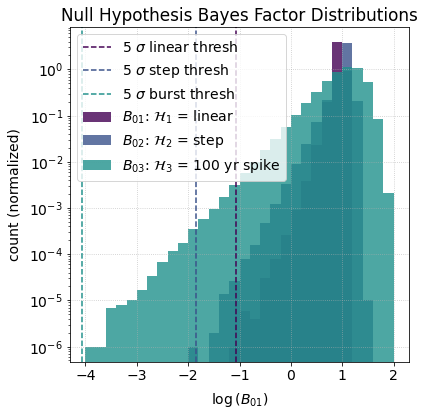

In [14]:
N = len(BF_lin_null)

sigs = [3,4,5]

i = np.array([np.maximum(int(norm.sf(x)*N)-1,0) for x in sigs])
print(i)

sig_thr = np.array([np.sort(nulls)[i] for nulls in BF_null])
print(sig_thr)

BFlim = (-20,50)

logBmin = np.maximum(np.round(np.log10(np.min(np.minimum(np.minimum(BF_lin_null, BF_100yr_null), BF_step_null)))),BFlim[0])
logBmax = np.minimum(np.round(np.log10(np.max(np.maximum(np.maximum(BF_lin_null, BF_100yr_null), BF_step_null)))),BFlim[1])
nbins = int(np.round((logBmax - logBmin) / 0.2) + 1)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.hist(np.log10(BF_lin_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{01}$: $\mathcal{H}_1$ = linear');
ax.hist(np.log10(BF_step_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{02}$: $\mathcal{H}_2$ = step');
ax.hist(np.log10(BF_100yr_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{03}$: $\mathcal{H}_3$ = 100 yr spike');
ax.axvline(np.log10(sig_thr[0,2]), ls = '--', c=colors[0], label=r'5 $\sigma$ linear thresh')
ax.axvline(np.log10(sig_thr[1,2]), ls = '--', c=colors[1], label=r'5 $\sigma$ step thresh')
ax.axvline(np.log10(sig_thr[2,2]), ls = '--', c=colors[2], label=r'5 $\sigma$ burst thresh')
ax.set(xlabel=r'$\log{(B_{01})}$',
       ylabel='count (normalized)',
       yscale='log')

ax.legend(loc='best')
plt.title('Null Hypothesis Bayes Factor Distributions')

fig.tight_layout()

Text(0.5, 1.0, 'Null Hypothesis Bayes Factor Distributions')

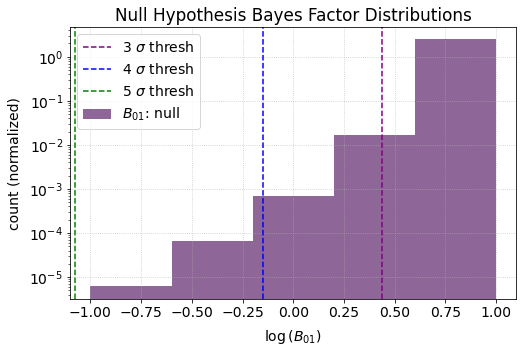

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

logBmin = np.round(np.log10(np.min(BF_null[0])))
logBmax = np.round(np.log10(np.max(BF_null[0])))
nbins = int(np.round((logBmax - logBmin) / 0.4) + 1)

ax.hist(np.log10(BF_null[0]), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.6, density=1,
        label=r'$B_{01}$: null');
ax.axvline(np.log10(sig_thr[0][0]), ls = '--', c='purple', label=r'3 $\sigma$ thresh')
ax.axvline(np.log10(sig_thr[0][1]), ls = '--', c='blue', label=r'4 $\sigma$ thresh')
ax.axvline(np.log10(sig_thr[0][2]), ls = '--', c='green', label=r'5 $\sigma$ thresh')
ax.set(xlabel=r'$\log{(B_{01})}$',
        ylabel='count (normalized)',
        yscale='log'
        )

ax.legend(loc='best')
plt.title('Null Hypothesis Bayes Factor Distributions')

### Bayes Factor: Linear Model, $3\sigma$ Sensitivity

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 740.47it/s]


[0.5466 0.1966 0.0375]
3 Sigma Amplitude Sensitivity: 0.93


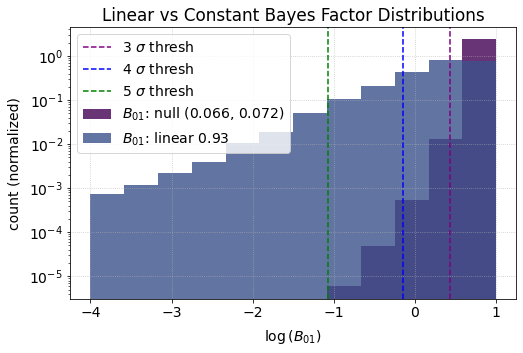

In [16]:
auto_search(1, False, 3)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 734.75it/s]


[0.6246 0.3135 0.0799]
3 Sigma Amplitude Sensitivity: 1.06


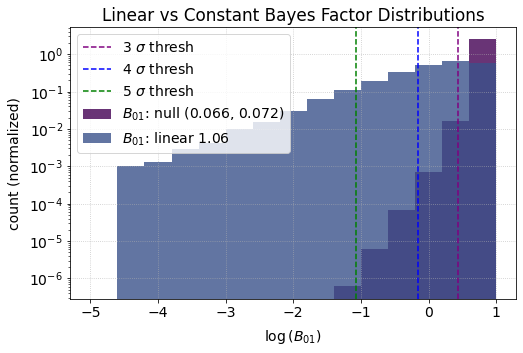

In [17]:
auto_search(1, True, 3)

### Bayes Factor: Linear Model, $5\sigma$ Sensitivity

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 734.00it/s]


[0.9915 0.9348 0.7142]
5 Sigma Amplitude Sensitivity: 0.89


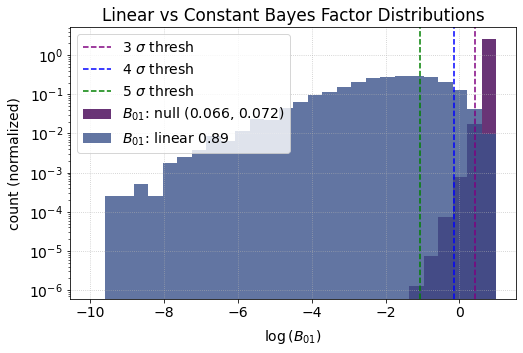

In [18]:
auto_search(1, False, 5)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 741.07it/s]


[0.9603 0.8483 0.5831]
5 Sigma Amplitude Sensitivity: 1.08


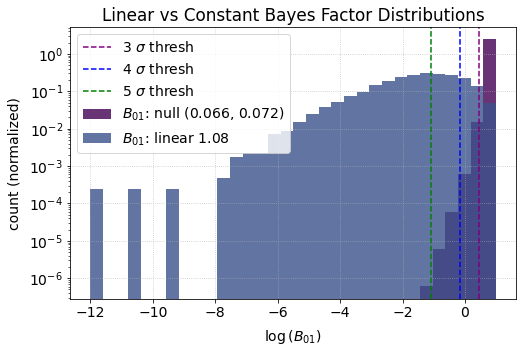

In [19]:
auto_search(1, True, 5)

### Bayes Factor: Step Model, $3\sigma$ Sensitivity

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 710.08it/s]


[0.5273 0.2226 0.0476]
3 Sigma Amplitude Sensitivity: 0.94


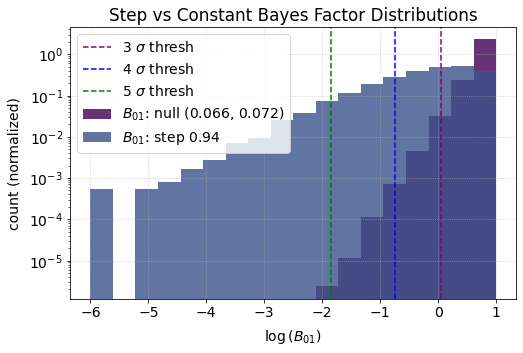

In [20]:
auto_search(2, False, 3)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 728.07it/s]


[0.7503 0.4584 0.1855]
3 Sigma Amplitude Sensitivity: 1.06


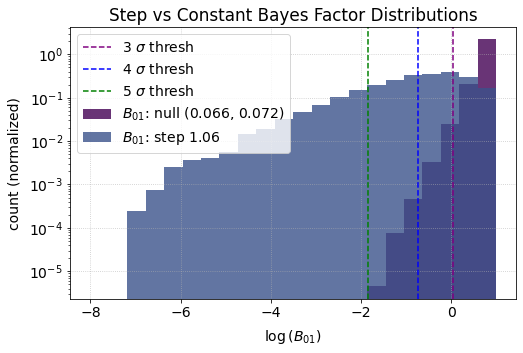

In [21]:
auto_search(2, True, 3)

### Bayes Factor: Step Model, $5\sigma$ Sensitivity

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 714.19it/s]


[0.9785 0.8873 0.6485]
5 Sigma Amplitude Sensitivity: 0.91


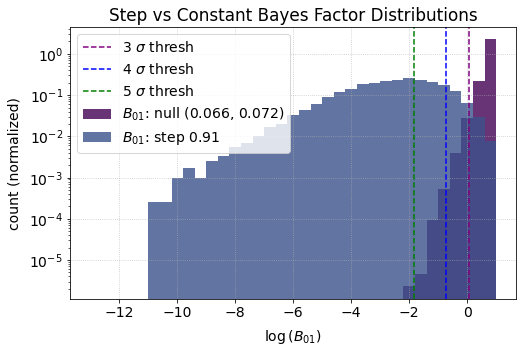

In [22]:
auto_search(2, False, 5)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 725.27it/s]


[0.9916 0.9497 0.7997]
5 Sigma Amplitude Sensitivity: 1.08


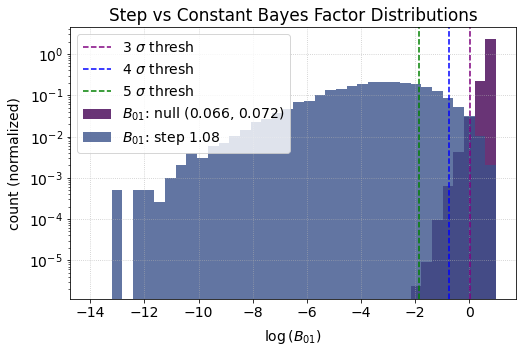

In [23]:
auto_search(2, True, 5)

### Bayes Factor: Burst Model, $3\sigma$ Sensitivity

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 926.87it/s]


[0.5297 0.188  0.0295]
3 Sigma Amplitude Sensitivity: 2.9


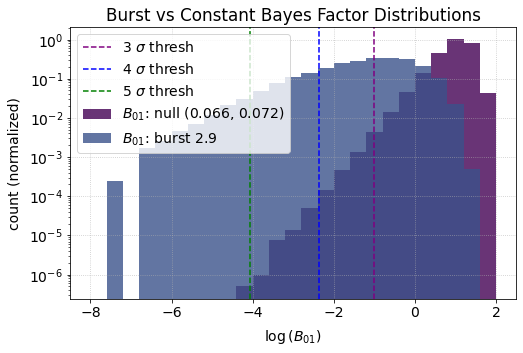

In [24]:
auto_search(3, True, 3)

### Bayes Factor: Burst Model, $5\sigma$ Sensitivity

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 872.37it/s]


[0.9753 0.8443 0.5201]
5 Sigma Amplitude Sensitivity: 4.1


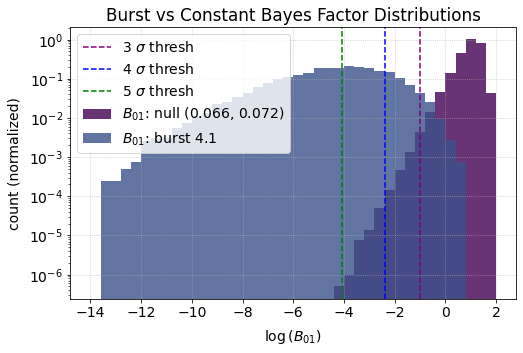

In [25]:
auto_search(3, True, 5)